# Grab spectograms from the H5 files, resize them to the first 100 ms but leave them as 2D arrays. 
## stick them in a np.array (X)
## Then we're going to analyze them- 
## for now that just invovles PCA them, UMAP that, and plot the results. May as well cluster them too.
## the plan is to use a neural network though

## Assume we have a folder with calls as .wav files (from soundsep)
## Produce a bunch of spectrograms for clustering. Probably do PCA, we'll see

In [1]:
# from scipy import integrate, optimize

import matplotlib.pyplot as plt
from scipy.signal import spectrogram, butter, sosfilt, sosfiltfilt, correlate
from scipy.io.wavfile import read, write
import IPython.display as ipd
# import sys
from collections import Counter
import os
import pandas as pd
# import pandas as pd
import numpy as np
import matplotlib.colors as mcolors
import pickle
import csv
from soundsig.sound import BioSound 
from soundsig.sound import WavFile

# Dimension reduction and clustering libraries
import umap
import hdbscan
import sklearn.cluster as cluster
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score
from sklearn.decomposition import PCA

In [2]:
desired_length = 100 # in ms # change if you want to play with this- all files will be truncated to this length or padded with zeros

base_folder = '/Users/williamwood/Documents/Data/Field Station Recordings/for_soundsep/14_38_03_18_07_2023'
wav_list = [f for f in os.listdir(os.path.join(base_folder,'wavs')) if f.endswith('.wav')]
# find the shortest file and the longest file but this isn't really necessary
# print(f'number of files: {len(wav_list)}')
wav_lengths = [read(os.path.join(base_folder,'wavs',f))[1].shape[0] for f in wav_list]  
shortest_file = wav_list[np.argmin(wav_lengths)]
# longest_file = wav_list[np.argmax(wav_lengths)]
# print(f' shortest file: {shortest_file} \n longest file: {longest_file}')
# # read the shortest file
fs, data = read(os.path.join(base_folder,'wavs', shortest_file))
# print(f'fs: {fs} \n data shape: {data.shape}, length: {data.shape[0]/fs} seconds')
# # read the longest file
# fs, data = read(os.path.join(base_folder,'wavs',longest_file))
# print(f'fs: {fs} \n data shape: {data.shape}, length: {data.shape[0]/fs} seconds')
print(f'fs = {fs} Hz, desired length = {desired_length} ms')
# desired_length = int(desired_length * fs) # in data points
# print(f'desired length: {desired_length} data points')


fs = 48000 Hz, desired length = 100 ms


In [3]:
# Wait I can do this in the H5 files
os.chdir(os.path.join(base_folder,'h5filesAmp'))
h5_files = [f for f in os.listdir() if f.endswith('.h5')]

tableStore = os.path.join(base_folder,'spec_results','vocSelTableSprectro.h5')
pcInfo = os.path.join(base_folder,'spec_results','vocSpectroPC.pkl')


## check the size of our spectrograms, verify they all have the same frequency bins (just errors if they don't)
## then just take the firs 100 ms (desired_length) of time bins and put them all in a np.array for sorting
## TODO potentially save the file list and the array (X) in an object or something

In [5]:
# Verify the size our spectrograms will be
# Set true if you want to normalize all spectrograms.
normFlg = True
#nPCs is the number of PCs that will be used in the first dimensionality reduction
nPCs = 50
# Read the files to allocate space for np array
count = 0
shapeSpectro = []
birdName = []
callType = []
lengths = list()
for fname in h5_files:
    myBioSound = BioSound()
    myBioSound.readh5(fname)
    lengths.append(len(myBioSound.sound))
    shapeSpectro.append(myBioSound.spectro.shape)
    # print(f'spectrogram shapes: {shapeSpectro[-1]}')
    birdName.append(np.array2string(myBioSound.emitter)[2:-1])
    callType.append(np.array2string(myBioSound.type)[2:-1])
    count += 1

shapeSpectro.sort()

num_freq_bins = [shape[0] for shape in shapeSpectro]
if len(np.unique(num_freq_bins)) > 1:
    print(f'WARNING: calls are not all the same length')  
    print(f'frequncy bins: {np.unique(num_freq_bins)}')
else:
    print(f'All spectrograms have {num_freq_bins[0]} frequency bins')
    num_freq_bins = num_freq_bins[0]
print(f'time bins are {myBioSound.to[1]-myBioSound.to[0]} ms')
num_time_bins = int((desired_length/1000)/(myBioSound.to[1]-myBioSound.to[0]))
print(f'We will be taking {num_time_bins} time bins')
print(f'Allocating space for {count} spectrograms, shape: {count} x {num_freq_bins} x {num_time_bins}')
X = np.zeros((count, num_freq_bins, num_time_bins))
time_bins = myBioSound.to[0:num_time_bins]
freq_bins = myBioSound.fo

All spectrograms have 101 frequency bins
time bins are 0.001 ms
We will be taking 100 time bins
Allocating space for 4344 spectrograms, shape: 4344 x 101 x 100


In [6]:
#plot a histogram of lengths of spectrograms
# you only need to do this if you're interested in what a good spectrogram lenght for your particular data is: I am goign to go with 100 ms for now

# plt.hist([s[1] for s in shapeSpectro], bins=100)
# plt.xlabel('Length of spectrogram')
# plt.ylabel('Number of spectrograms')
# plt.title('Histogram of lengths of spectrograms')
# # print the mode
# print(f'Mode of spectrogram lengths: {Counter([s[1] for s in shapeSpectro]).most_common(1)}')

# # plot a histogram of lengths of calls
# plt.figure()
# plt.hist(lengths, bins=100)
# plt.xlabel('Length of call')
# plt.ylabel('Number of calls')
# plt.title('Histogram of lengths of calls')
# # print the mode
# print(f'Mode of call lengths: {Counter(lengths).most_common(1)}')
  


In [23]:
# check all the spectrogram shapes and adjust them to the desired length
for i, file in enumerate(h5_files):
    myBioSound = BioSound()
    myBioSound.readh5(file)
    if myBioSound.spectro.shape[1] < num_time_bins:
        myBioSound.spectro = np.pad(myBioSound.spectro, ((0,0),(0,num_time_bins-myBioSound.spectro.shape[1])), 'constant')
        X[i,:,:] = myBioSound.spectro
    elif myBioSound.spectro.shape[1] > num_time_bins: # if it's longer than desired, truncate it taking the first num_time_bins, TODO take the center of the syllable instead or make it optional
        X[i,:,:] = myBioSound.spectro[:,:num_time_bins]
    else:
        X[i,:,:] = myBioSound.spectro

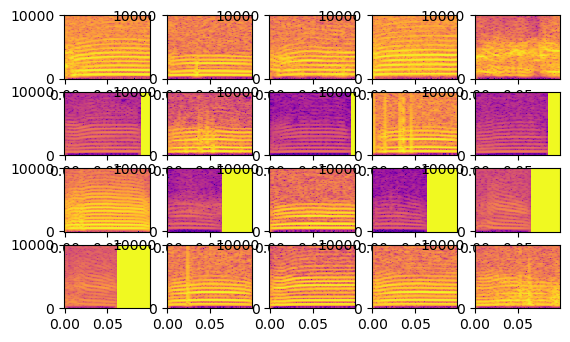

In [32]:
# you can plot a couple of the spectograms to make sure they look ok by changing the index
index = 60
plt.figure()
plt.subplot(5,5,1)
plt.pcolormesh(time_bins, freq_bins, X[index,:,:], cmap='plasma', shading='auto')
plt.subplot(5,5,2)
plt.pcolormesh(time_bins, freq_bins, X[index+1,:,:], cmap='plasma', shading='auto')
plt.subplot(5,5,3)
plt.pcolormesh(time_bins, freq_bins, X[index+2,:,:], cmap='plasma', shading='auto')
plt.subplot(5,5,4)
plt.pcolormesh(time_bins, freq_bins, X[index+3,:,:], cmap='plasma', shading='auto')
plt.subplot(5,5,5)
plt.pcolormesh(time_bins, freq_bins, X[index+4,:,:], cmap='plasma', shading='auto')
plt.subplot(5,5,6)
plt.pcolormesh(time_bins, freq_bins, X[index+5,:,:], cmap='plasma', shading='auto')
plt.subplot(5,5,7)
plt.pcolormesh(time_bins, freq_bins, X[index+6,:,:], cmap='plasma', shading='auto')
plt.subplot(5,5,8)
plt.pcolormesh(time_bins, freq_bins, X[index+7,:,:], cmap='plasma', shading='auto')
plt.subplot(5,5,9)
plt.pcolormesh(time_bins, freq_bins, X[index+8,:,:], cmap='plasma', shading='auto')
plt.subplot(5,5,10)
plt.pcolormesh(time_bins, freq_bins, X[index+9,:,:], cmap='plasma', shading='auto')
plt.subplot(5,5,11)
plt.pcolormesh(time_bins, freq_bins, X[index+10,:,:], cmap='plasma', shading='auto')
plt.subplot(5,5,12)
plt.pcolormesh(time_bins, freq_bins, X[index+11,:,:], cmap='plasma', shading='auto')
plt.subplot(5,5,13)
plt.pcolormesh(time_bins, freq_bins, X[index+12,:,:], cmap='plasma', shading='auto')
plt.subplot(5,5,14)
plt.pcolormesh(time_bins, freq_bins, X[index+13,:,:], cmap='plasma', shading='auto')
plt.subplot(5,5,15)
plt.pcolormesh(time_bins, freq_bins, X[index+14,:,:], cmap='plasma', shading='auto')
plt.subplot(5,5,16)
plt.pcolormesh(time_bins, freq_bins, X[index+15,:,:], cmap='plasma', shading='auto')
plt.subplot(5,5,17)
plt.pcolormesh(time_bins, freq_bins, X[index+16,:,:], cmap='plasma', shading='auto')
plt.subplot(5,5,18)
plt.pcolormesh(time_bins, freq_bins, X[index+17,:,:], cmap='plasma', shading='auto')
plt.subplot(5,5,19)
plt.pcolormesh(time_bins, freq_bins, X[index+18,:,:], cmap='plasma', shading='auto')
plt.subplot(5,5,20)
plt.pcolormesh(time_bins, freq_bins, X[index+19,:,:], cmap='plasma', shading='auto')
plt.show()




In [33]:
# save the spectrograms to a file
np.save(os.path.join(base_folder,'spec_results','spectrograms.npy'), X)